# Подключение библиотек

In [ ]:
# Установка Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Здесь “name of the competition” — не название жирным шрифтом, отображаемое на заднем плане.
# Это фрагмент ссылки на competition, который следует после “/c/”.
# Вот пример ссылки:
# “https://www.kaggle.com/c/playground-series-s4e4"

! kaggle competitions download playground-series-s4e4
! unzip playground-series-s4e4

# Начало работы

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


!pip install catboost
!pip install optuna
# Модели обучения
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# Подбор гиперпараметров
import optuna

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.7 MB/s eta 0:00:00


## Анализ задания соренования

    Задача: спрогнозировать количество колец на раковинах морских ушек на основе набора данных
    
    Набор данных: предоставлены обучающие и тестовые наборы данных

    Цель: разработать модели машинного обучения для точного прогнозирования количества колец на раковинах морских ушек.

    Оценка: Показателем оценки в этом соревновании является среднеквадратическая логарифмическая ошибка.

### Импорт данных, и их первичный анализ

In [90]:
# Загрузка данных (чтение их csv файла)
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

# Запомним на будущее
indexes = test['id']

In [ ]:
train

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


from matplotlib import pyplot as plt
train['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train['Length'].plot(kind='hist', bins=20, title='Length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train['Diameter'].plot(kind='hist', bins=20, title='Diameter')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train['Height'].plot(kind='hist', bins=20, title='Height')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('Sex').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train.plot(kind='scatter', x='id', y='Length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train.plot(kind='scatter', x='Length', y='Diameter', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train.plot(kind='scatter', x='Diameter', y='Height', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train.plot(kind='scatter', x='Height', y='Whole weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['Length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Sex')):
  _plot_series(series, series_name, i)
  fig.legend(title='Sex', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('Length')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['Diameter']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Sex')):
  _plot_series(series, series_name, i)
  fig.legend(title='Sex', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('Diameter')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['Height']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Sex')):
  _plot_series(series, series_name, i)
  fig.legend(title='Sex', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('Height')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['Whole weight']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Sex')):
  _plot_series(series, series_name, i)
  fig.legend(title='Sex', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('Whole weight')

from matplotlib import pyplot as plt
train['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
train['Length'].plot(kind='line', figsize=(8, 4), title='Length')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
train['Diameter'].plot(kind='line', figsize=(8, 4), title='Diameter')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
train['Height'].plot(kind='line', figsize=(8, 4), title='Height')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train['Sex'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='id', y='Sex', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train['Sex'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='Length', y='Sex', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train['Sex'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='Diameter', y='Sex', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train['Sex'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='Height', y='Sex', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Посмотрим на имеющиеся колонки (пока можно подумать - "Возможно ли как-то расширить колличесвто признаков....")
train.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')

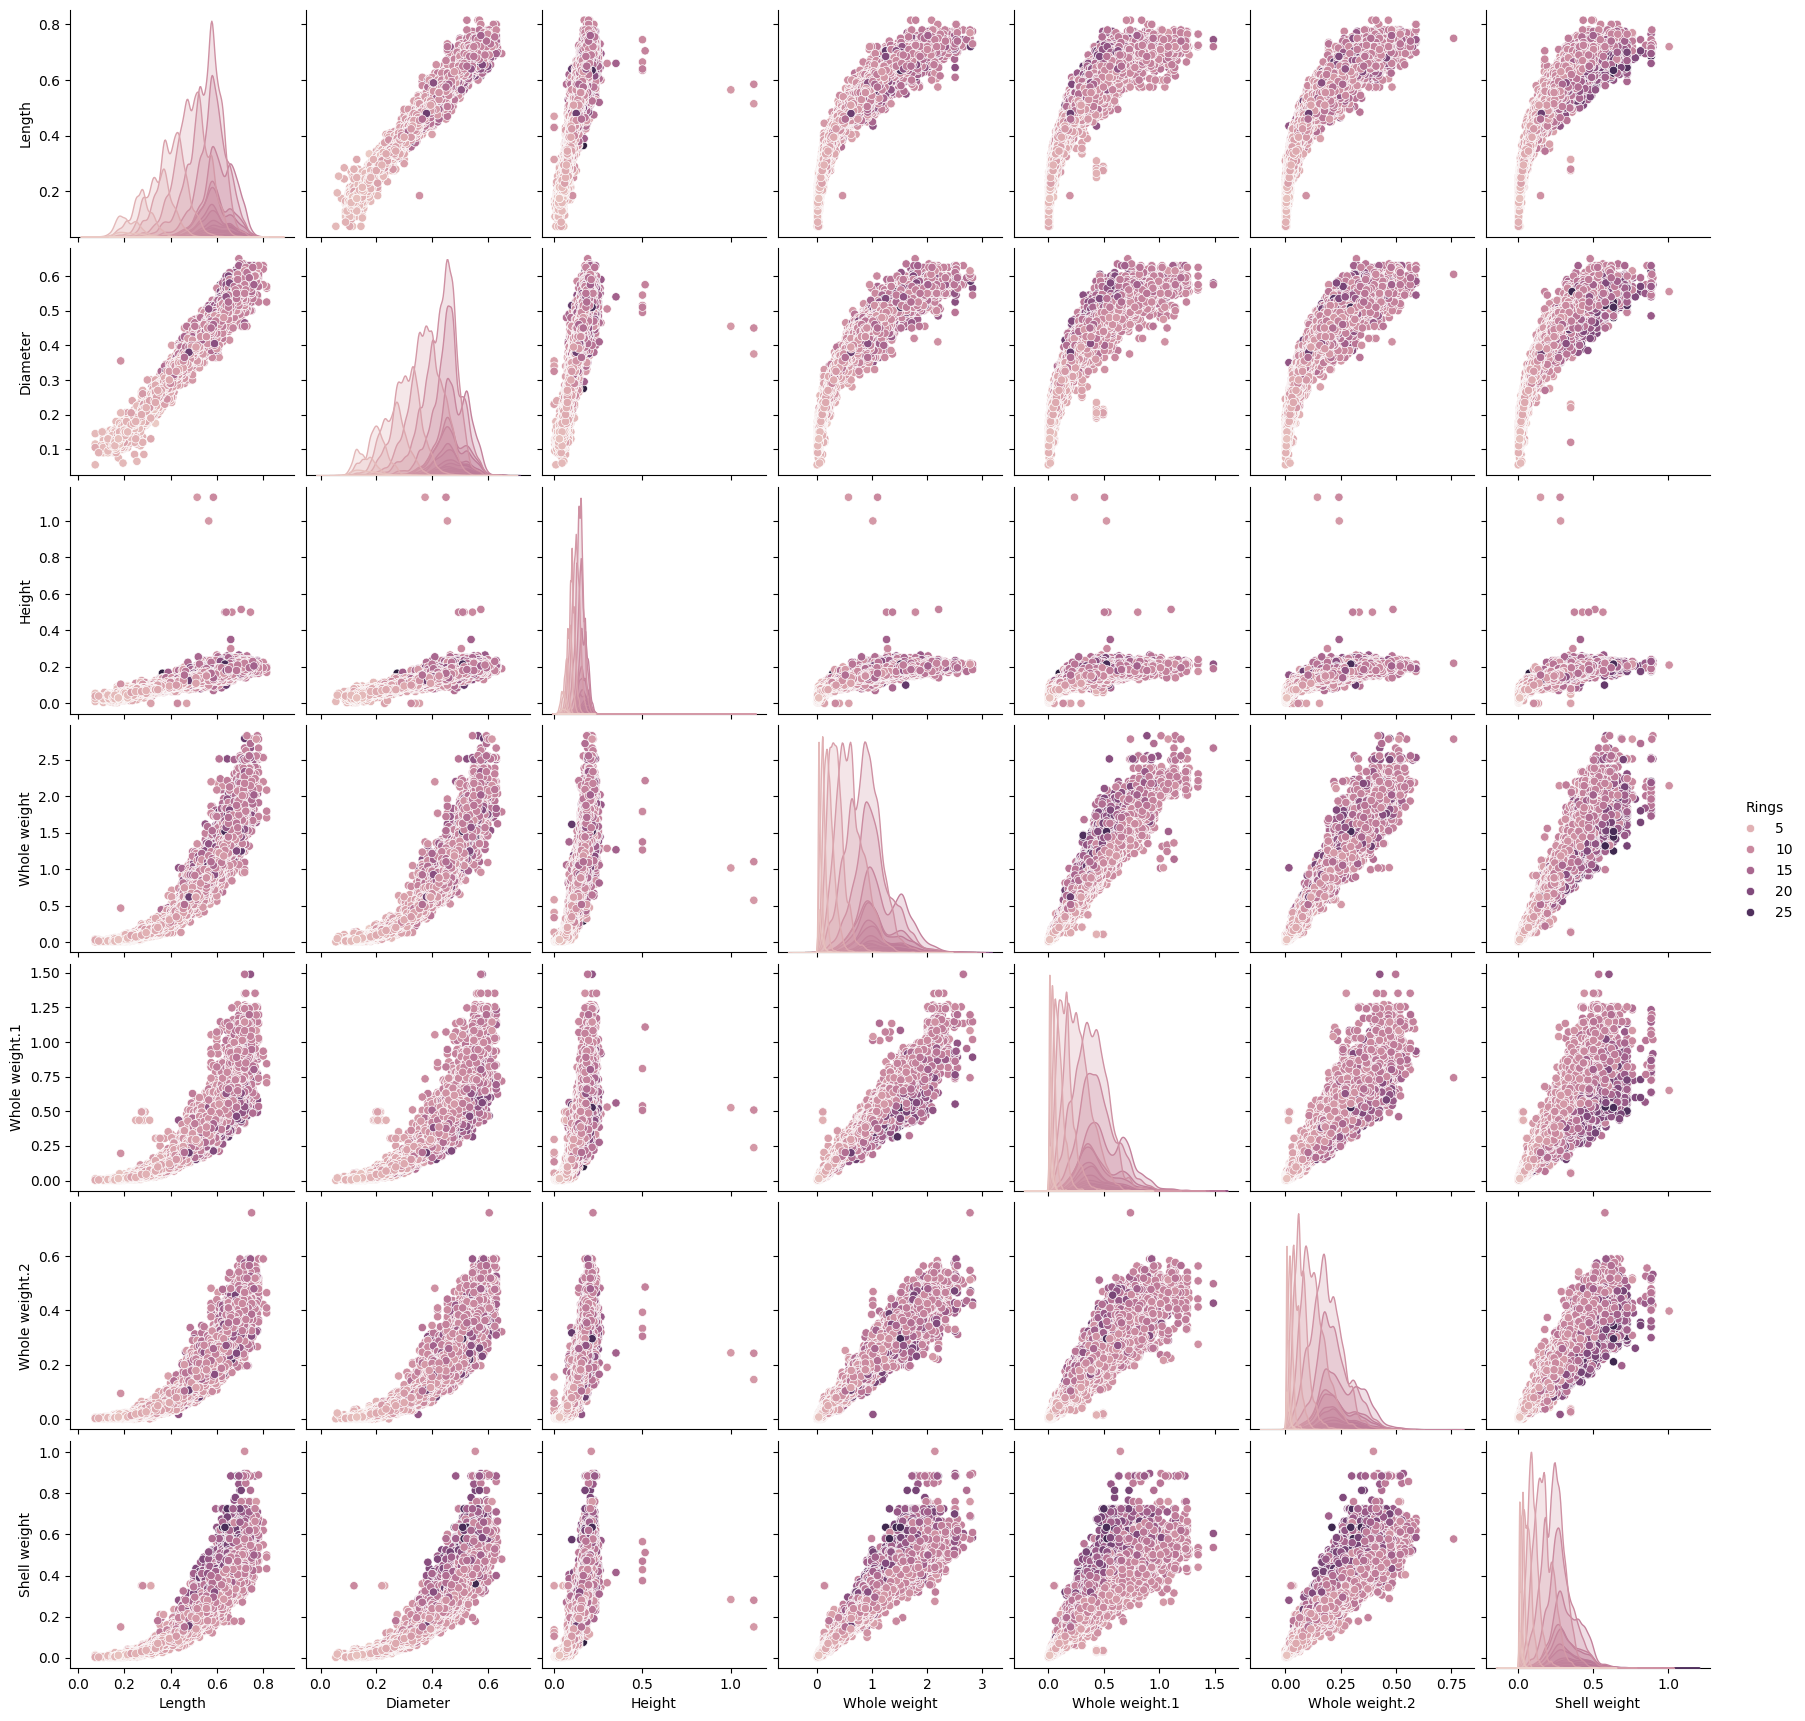

In [ ]:
# Визуализируем имеющиеся данные
sns.pairplot(train[['Sex',
                    'Length',
                    'Diameter',
                    'Height',
                    'Whole weight',
                    'Whole weight.1',
                    'Whole weight.2',
                    'Shell weight',
                    'Rings']], hue='Rings')
# Визуализация достаточно долгая, поэтому пока можем - любуемся

In [ ]:
# Первым делом удостоверимся, что мы имеем все данные, и нам не нужно ничего заполнять дополнительно
train.isna().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [5]:
# При просмотре имеющегося датасета, мы могли увидеть там категориальный признак в колонке "Sex"
# Для кодировки этой колонки воспользуемся .LabelEncoder
le = LabelEncoder()

train["Sex"] = le.fit_transform(train["Sex"])
test["Sex"]  = le.transform(test["Sex"])

In [ ]:
# Таким образом получаем следующий датасет
train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [6]:
# Теперь попробуем добавить в наш датафрейм новые колонки
# 1 - Радиус
# 1 - Площадь поверхности
# 2 - Объем
# 4 - Отношение длины к диаметру
# 5 - Средний вес устрицы
# 6 - Индекс кондиции
# 7 - Плотность

# Для train
train['Radius'] = train['Diameter'] / 2                                                                     # Радиус
train['SurfaceArea'] = 2 * math.pi * train['Radius'] * (train['Radius'] + train['Height'])                  # Площадь поверхности
train['Volume'] = (4/3) * math.pi * pow(train['Radius'], 2) * train['Height']                               # Объем
train['Length-to-Diameter'] = train['Length'] / train['Diameter']                                           # Отношение длины к диаметру
train['AverageWeight'] = (train['Whole weight'] + train['Whole weight.1'] + train['Whole weight.2']) / 3    # Средний вес устрицы
train['ConditionIndex'] = train['Whole weight'] / (train['Length'] + train['Diameter'] + train['Height'])   # Индекс кондиции
train['ConditionIndex.1'] = train['Whole weight.1'] / (train['Length'] + train['Diameter'] + train['Height']) # Индекс кондиции
train['ConditionIndex.2'] = train['Whole weight.2'] / (train['Length'] + train['Diameter'] + train['Height']) # Индекс кондиции
train['Density'] = train['Whole weight'] / train['Volume']                                                   # Плотность
train['Density.1'] = train['Whole weight.1'] / train['Volume']                                               # Плотность
train['Density.2'] = train['Whole weight.2'] / train['Volume']                                               # Плотность

# Тепрь тоже самое для test
# Для train
test['Radius'] = test['Diameter'] / 2                                                                  # Радиус
test['SurfaceArea'] = 2 * math.pi * test['Radius'] * (test['Radius'] + test['Height'])                 # Площадь поверхности
test['Volume'] = (4/3) * math.pi * pow(test['Radius'], 2) * test['Height']                             # Объем
test['Length-to-Diameter'] = test['Length'] / test['Diameter']                                         # Отношение длины к диаметру
test['AverageWeight'] = (test['Whole weight'] + test['Whole weight.1'] + test['Whole weight.2']) / 3   # Средний вес устрицы
test['ConditionIndex'] = test['Whole weight'] / (test['Length'] + test['Diameter'] + test['Height'])   # Индекс кондиции
test['ConditionIndex.1'] = test['Whole weight.1'] / (test['Length'] + test['Diameter'] + test['Height']) # Индекс кондиции
test['ConditionIndex.2'] = test['Whole weight.2'] / (test['Length'] + test['Diameter'] + test['Height']) # Индекс кондиции
test['Density'] = test['Whole weight'] / test['Volume']                                                # Плотность
test['Density.1'] = test['Whole weight.1'] / test['Volume']                                            # Плотность
test['Density.2'] = test['Whole weight.2'] / test['Volume']                                            # Плотность

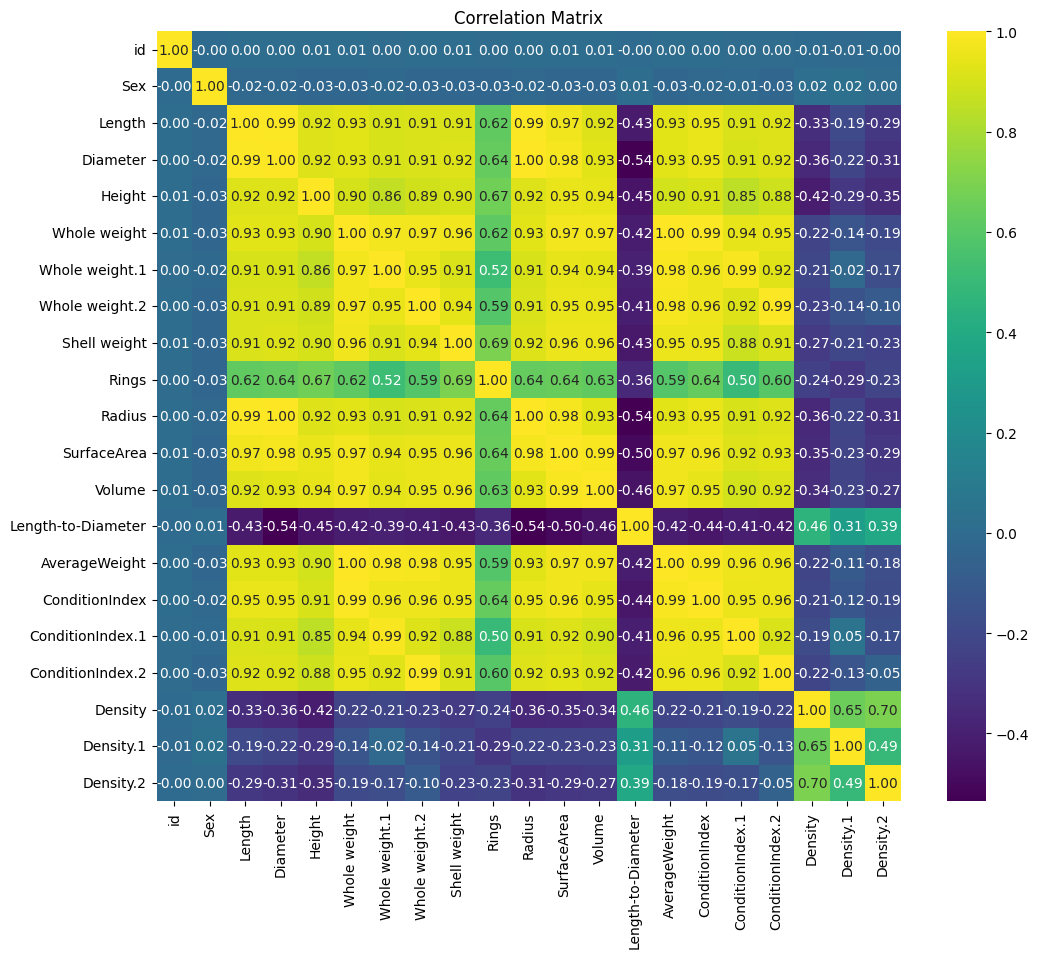

In [ ]:
# Посмотрим, получилось ли нам создать новые переменные имеющую высокую корреляция с исходными данными..
corr_matrix = train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
train.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings', 'Radius',
       'SurfaceArea', 'Volume', 'Length-to-Diameter', 'AverageWeight',
       'ConditionIndex', 'ConditionIndex.1', 'ConditionIndex.2', 'Density',
       'Density.1', 'Density.2'],
      dtype='object')

In [7]:
# Тут мы видим, что некоторые из созданных колонок имеют бесконечное значение - inf
#train.describe()

# Тогда удалим эти колонки
train.drop(['Density', 'Density.1', 'Density.2'], axis=1, inplace=True)
test.drop(['Density', 'Density.1', 'Density.2'], axis=1, inplace=True)

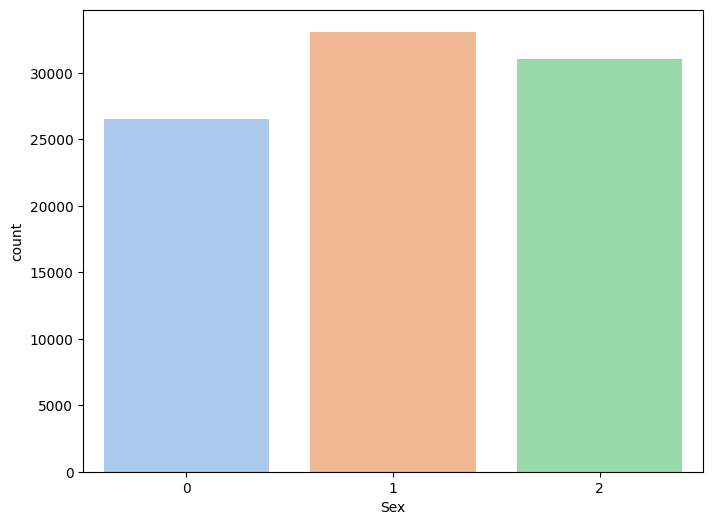

In [ ]:
# Проанализаруем распределение даннхы по полу
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', data=train, palette='pastel')
plt.show()

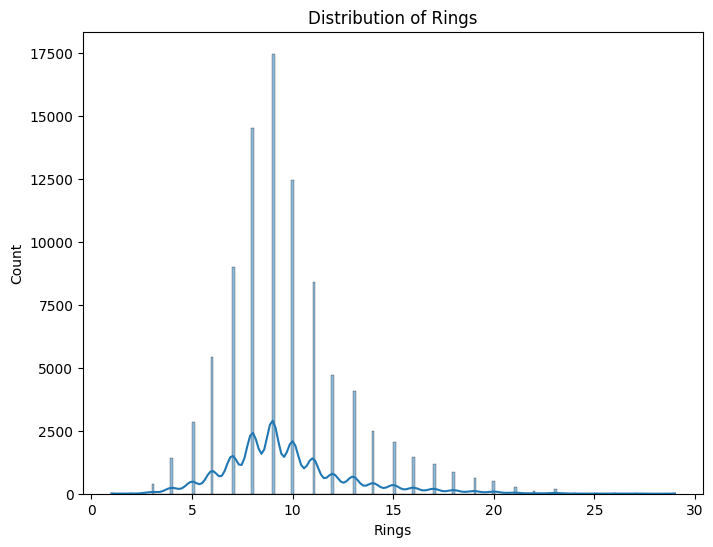

In [ ]:
# Так же обратим внимание на распределение колец
plt.figure(figsize=(8, 6))
sns.histplot(train['Rings'], kde=True)
plt.title('Distribution of Rings')
plt.xlabel('Rings')
plt.show()

In [8]:
# Нам остаётся удалить колонку id, и приступить к обучению модели
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [ ]:
# Тогда наш датасет будет выгллядеть так
train

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Radius,SurfaceArea,Volume,Length-to-Diameter,AverageWeight,ConditionIndex,ConditionIndex.1,ConditionIndex.2,Density,Density.1,Density.2
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,0.2150,0.493073,0.029044,1.279070,0.415500,0.682743,0.290708,0.129646,26.563124,11.310416,5.044067
1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,0.2450,0.600358,0.036458,1.285714,0.621500,0.893281,0.362055,0.218577,30.994859,12.562518,7.584140
2,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0.0550,0.027646,0.000317,1.454545,0.009833,0.071186,0.018644,0.010169,66.292637,17.362357,9.470377
3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0.2375,0.578249,0.035441,1.252632,0.498500,0.749590,0.307787,0.168443,25.803381,10.595046,5.798354
4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0.2125,0.457298,0.024590,1.305882,0.437167,0.704505,0.332883,0.144144,31.802182,15.026734,6.506840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90610,2,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6,0.1175,0.142118,0.004337,1.425532,0.088000,0.245736,0.106202,0.057364,36.542955,15.793012,8.530532
90611,2,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9,0.2125,0.484002,0.028373,1.305882,0.482333,0.777876,0.342035,0.160619,30.980694,13.622341,6.397037
90612,1,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6,0.1650,0.269549,0.010834,1.318182,0.183667,0.373837,0.175581,0.091279,29.675693,13.937884,7.245854
90613,1,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6,0.1350,0.178128,0.005726,1.277778,0.115667,0.289855,0.142029,0.071014,34.931126,17.116252,8.558126


In [ ]:
train.describe()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Radius,SurfaceArea,Volume,Length-to-Diameter,AverageWeight,ConditionIndex,ConditionIndex.1,ConditionIndex.2
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,1.050014,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794,0.200840,0.450243,0.026909,1.295142,0.433078,0.682286,0.294447,0.146376
std,0.795174,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221,0.049013,0.196141,0.016417,0.059678,0.252176,0.290912,0.132412,0.065199
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,0.027500,0.006480,0.000000,0.517241,0.001333,0.006780,0.003509,0.000806
25%,0.000000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000,0.172500,0.304420,0.013572,1.262136,0.229167,0.464407,0.198361,0.095980
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000,0.212500,0.470650,0.026481,1.288889,0.433833,0.713023,0.296414,0.148372
75%,2.000000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000,0.235000,0.580684,0.036855,1.321839,0.586167,0.871667,0.380769,0.190514
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,0.325000,1.915586,0.239625,3.923077,1.547833,1.914885,1.002020,0.482540


### Модель обучения

In [9]:
# Зафиксируем рандом
seed = np.random.seed(23)

X = train.drop(["Rings"],axis=1)
y = train["Rings"]

# Масштабириуем имеющиеся данные
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
test = scaler.transform(test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

In [19]:
# Объявляем функцию метрики
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Создадим функцию для поиска гиперпараметров xgboost
def optimize_xgb_hyperparameters(X, y, n_trials=100):
    # Разбиваем данные на обучающий и тестовый наборы
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Определяем функции для оптимизации
    def objective(trial):
        # Гиперпараметры для подбора
        params = {
            'objective': 'reg:squarederror',                                            # Функция потерь для регрессии
            'eval_metric': 'rmsle',                                                     # Метрика оценки качества
            'booster': 'gbtree',                                                        # Используемый алгоритм обучения
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),               # Количество деревьев
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),          # Скорость обучения
            'max_depth': trial.suggest_int('max_depth', 3, 10),                         # Максимальная глубина деревьев
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),                    # Доля подвыборки при построении каждого дерева
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),      # Доля признаков при построении каждого дерева
            'gamma': trial.suggest_float('gamma', 0, 5),                                # Минимальное уменьшение значения функции потерь для разделения узла
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),                        # L1-регуляризация
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),                      # L2-регуляризация
            'tree_method': 'hist',
            'random_state': seed
        }

        # Создание модели
        model = XGBRegressor(**params)
        # Обучение модели
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
        # Предсказание на валидационном наборе
        y_pred = model.predict(X_val)
        # Вычисление метрики RMSLE
        rmsle_score = rmsle(y_val, y_pred)
        return rmsle_score

    # Создание и запуск Study с оптимизацией по минимизации RMSLE
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Вывод результатов
    print('Best parameters:', study.best_params)
    print('Best RMSLE:', study.best_value)

    return study.best_params



# Создадим аналогичные функции для двух других методов
# Создадим функцию для поиска гиперпараметров lightgbm
def optimize_lgb_hyperparameters(X, y, n_trials=100):
    # Разбиваем данные на обучающий и тестовый наборы
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Определяем функции для оптимизации
    def objective(trial):
        # Гиперпараметры для подбора
        params = {
            'objective': 'regression',                                              # Функция потерь для регрессии
            'metric': 'rmsle',                                                      # Метрика оценки качества
            'boosting_type': 'gbdt',                                                # Тип алгоритма обучения
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),           # Количество деревьев
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),      # Скорость обучения
            'max_depth': trial.suggest_int('max_depth', 3, 15),                     # Максимальная глубина деревьев
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),                # Доля подвыборки при построении каждого дерева
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Доля признаков при построении каждого дерева
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),                    # L1-регуляризация
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),                  # L2-регуляризация
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),                 # Максимальное количество листьев в дереве
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),    # Минимальное количество образцов в листе
            'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),           # Частота подвыборки
            'random_state': seed
        }

        # Создание модели
        model = LGBMRegressor(**params)
        # Обучение модели
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        # Предсказание на валидационном наборе
        y_pred = model.predict(X_val)
        # Вычисление метрики RMSLE
        rmsle_score = rmsle(y_val, y_pred)
        return rmsle_score

    # Создание и запуск Study с оптимизацией по минимизации RMSLE
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Вывод результатов
    print('Best parameters:', study.best_params)
    print('Best RMSLE:', study.best_value)

    return study.best_params



# Создадим функцию для поиска гиперпараметров catboost
def optimize_cat_hyperparameters(X, y, n_trials=100):
    # Разбиваем данные на обучающий и тестовый наборы
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

    def rmsle_catboost(y_true, y_pred):
        assert len(y_true) == len(y_pred)
        terms_to_sum = [(np.log1p(y_pred[i] + 1) - np.log1p(y_true[i] + 1)) ** 2.0 for i in range(len(y_true))]
        return 'rmsle', (sum(terms_to_sum) * (1.0 / len(y_true))) ** 0.5, False

    # Определяем функции для оптимизации
    def objective(trial):
        # Гиперпараметры для подбора
        params = {
            'loss_function': 'RMSE',                                                                               # Функция потерь для регрессии
            'iterations': trial.suggest_int('iterations', 100, 1000),                                              # Количество итераций (деревьев)
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),                                     # Скорость обучения
            'depth': trial.suggest_int('depth', 4, 10),                                                            # Максимальная глубина деревьев
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),               # Доля признаков при построении каждого дерева на каждом уровне
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),                                              # L2-регуляризация
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),                               # Температура для сэмплирования объектов
            'random_strength': trial.suggest_float('random_strength', 0, 1),                                       # Сила случайного сэмплирования
            'border_count': trial.suggest_int('border_count', 1, 255),                                             # Количество бинов для числовых признаков
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),  # Стратегия роста дерева
            'random_state': seed
        }


        # Создание модели
        model = CatBoostRegressor(**params)
        # Обучение модели
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
        # Предсказание на валидационном наборе
        y_pred = model.predict(X_val)
        # Вычисление метрики RMSLE
        rmsle_score = rmsle(y_val, y_pred)
        return rmsle_score

    # Создание и запуск Study с оптимизацией по минимизации RMSLE
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Вывод результатов
    print('Best parameters:', study.best_params)
    print('Best RMSLE:', study.best_value)

    return study.best_params


#### Обучение xgboost

In [ ]:
# # Найдём наилучшие параметры для xgboost
# best_params_xgb = optimize_xgb_hyperparameters(X_train, y_train, n_trials=150)

In [11]:
Best_parameters_xgb = {'n_estimators': 897,
                        'learning_rate': 0.011596114639631673,
                        'max_depth': 8,
                        'subsample': 0.7386009138440929,
                        'colsample_bytree': 0.6520794356252213,
                        'gamma': 2.0696357101914007,
                        'reg_alpha': 2.3712258437419247,
                        'reg_lambda': 3.988503751652587}

Best_RMSLE_xgb = 0.1500545011380431

#### Обучение lightgbm

In [ ]:
# # Найдём наилучшие параметры для lightgbm
# best_params_lgb = optimize_lgb_hyperparameters(X_train, y_train, n_trials=150)

In [12]:
Best_parameters_lgb = {'n_estimators': 556,
                        'learning_rate': 0.019949437731193037,
                        'max_depth': 8,
                        'subsample': 0.833415162483091,
                        'colsample_bytree': 0.5517351520890101,
                        'reg_alpha': 2.7093571041182956,
                        'reg_lambda': 3.1972100711071567,
                        'num_leaves': 91,
                        'min_child_samples': 23,
                        'subsample_freq': 1}

Best_RMSLE_lgb = 0.1515647233154047

#### Обучение catboost

In [22]:
# # Найдём наилучшие параметры для catboost
# best_params_cat = optimize_cat_hyperparameters(X_train, y_train, n_trials=170)

In [13]:
Best_parameters_cat = {'iterations': 333,
                       'learning_rate': 0.01790491652302067,
                       'depth': 10,
                       'colsample_bylevel': 0.7838346683835841,
                       'l2_leaf_reg': 2.7556089983177365,
                       'bagging_temperature': 0.06031869234672553,
                       'random_strength': 0.3055756892527741,
                       'border_count': 251,
                       'grow_policy': 'Depthwise'}

Best_RMSLE_cat = 0.1491511841580718

### Найдём веса для используемых ансаблей

In [ ]:
def get_predictions(models_and_params, X_test):
    y_preds = {}                                                                # Словарь для хранения предсказаний для каждой модели

    # Итерация по моделям и их параметрам
    for model_name, (model_class, best_params) in models_and_params.items():
        model = model_class(**best_params)                                      # Инициализация модели с лучшими параметрами
        model.fit(X_train, y_train)                                             # Обучение модели на тренировочных данных
        y_pred = model.predict(X_test)                                          # Получение предсказаний на тестовых данных
        y_preds[model_name] = y_pred                                            # Сохранение предсказаний в словаре

    return y_preds

models_and_params = {
    'XGBoost':  (XGBRegressor,      Best_parameters_xgb),
    'LightGBM': (LGBMRegressor,     Best_parameters_lgb),
    'CatBoost': (CatBoostRegressor, Best_parameters_cat)
}

y_preds = get_predictions(models_and_params, X_val)

# Теперь y_preds содержит предсказания для каждой модели
y_pred_xgb = y_preds['XGBoost']
y_pred_lgb = y_preds['LightGBM']
y_pred_cat = y_preds['CatBoost']

In [ ]:
def tune_ensemble_weights(y_pred_xgb, y_pred_lgbm, y_pred_catboost, y_val):
    def objective(trial):
        # Определение пространства поиска для весов
        weight_xgb = trial.suggest_float('weight_xgb', 0.0, 1.0)
        weight_lgbm = trial.suggest_float('weight_lgbm', 0.0, 1.0 - weight_xgb)
        weight_catboost = 1.0 - weight_xgb - weight_lgbm

        # Взвешенное усреднение
        ensemble_preds = (weight_xgb * y_pred_xgb + weight_lgbm * y_pred_lgbm + weight_catboost * y_pred_catboost)
        # Оценка производительности с использованием кросс-валидации
        rmslemet = rmsle(y_val, ensemble_preds)

        return rmslemet

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)

    # Получение лучших весов
    best_weights = study.best_params
    return best_weights


best_weights = tune_ensemble_weights(y_pred_xgb, y_pred_lgb, y_pred_cat, y_val)

In [ ]:
# Сфомируем предикты для test
def get_predictions(models_and_params, X_test):
    y_preds = {}                                                                # Словарь для хранения предсказаний для каждой модели

    # Итерация по моделям и их параметрам
    for model_name, (model_class, best_params) in models_and_params.items():
        model = model_class(**best_params)                                      # Инициализация модели с лучшими параметрами
        model.fit(X, y)                                                         # Обучение модели на тренировочных данных
        y_pred = model.predict(X_test)                                          # Получение предсказаний на тестовых данных
        y_preds[model_name] = y_pred                                            # Сохранение предсказаний в словаре

    return y_preds

y_preds = get_predictions(models_and_params, test)

# Теперь y_preds содержит предсказания для каждой модели
y_pred_xgb = y_preds['XGBoost']
y_pred_lgb = y_preds['LightGBM']
y_pred_cat = y_preds['CatBoost']

In [68]:
def combine_predictions(y_pred_xgb, y_pred_lgbm, y_pred_catboost, weights):
    weight_xgb, weight_lgbm = weights.items()
    weight_xgb = weight_xgb[1]
    weight_lgbm = weight_lgbm[1]
    weight_catboost = 1.0 - weight_xgb - weight_lgbm                                                             # Распаковываем веса
    final_pred = (weight_xgb * y_pred_xgb) + (weight_lgbm * y_pred_lgbm) + (weight_catboost * y_pred_catboost)   # Формируем итоговый ответ
    return final_pred

final_pred = combine_predictions(y_pred_xgb, y_pred_lgb, y_pred_cat, best_weights)

In [92]:
submission = pd.DataFrame()
submission["id"] = indexes
submission["Rings"] = final_pred
submission["Rings"] = np.round(submission["Rings"])


submission.to_csv("submission.csv",header=True,index=False)
submission

,id,Rings
0,90615,10.0
1,90616,10.0
2,90617,10.0
3,90618,10.0
4,90619,8.0
...,...,...
60406,151021,7.0
60407,151022,9.0
60408,151023,13.0
60409,151024,14.0
